In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

from sklearn.decomposition import PCA

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

from collections import Counter

rng = np.random.RandomState(0)



In [84]:
def print_class_distribution(y):
    labels = np.unique(y)
    class_distrib = Counter(y).most_common(len(labels))
    print(f"classes distribution {class_distrib}")

def fetch_data():
   
    # if you need to download them again
    # dataset_remote = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
    # label_remote = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
    dataset_local = "secom.data"
    label_local = "secom_labels.data"
    data_df = pd.read_csv(dataset_local, sep=" ", header=None, names=[f"F{i+1:03d}" for i in range(590)])
    label_df = pd.read_csv(label_local, sep=" ", header=None, names=["Label", "Time"], parse_dates=["Time"], dayfirst=True)
    df = pd.concat([label_df, data_df], axis=1)
    
    # keep only label, not time
    y = label_df.iloc[:, 0].values
    # set N/A to 0 and keep values
    X = data_df.fillna(0).to_numpy()
    print(f"X shape {X.shape}")
    print(f"y shape {y.shape}")

    print_class_distribution(y)
    
    return X, y

X, y = fetch_data()


X shape (1567, 590)
y shape (1567,)
classes distribution [(-1, 1463), (1, 104)]


PCA: Top 2 components explain 81% of variance


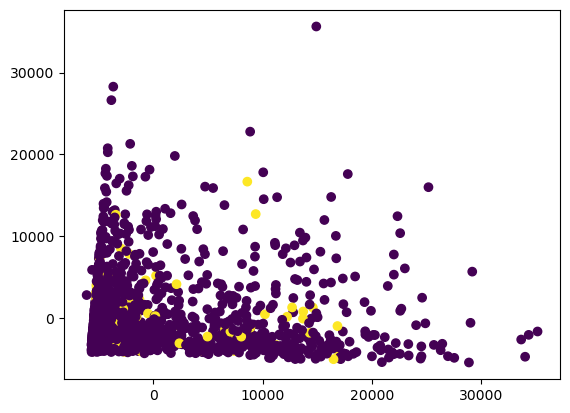

In [85]:
if (X.shape[1]!=2):
    # if more than 2 dimensions
    # make a PCA and plot 2 top components
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    total_var = pca.explained_variance_ratio_.sum() * 100
    print(f"PCA: Top 2 components explain {total_var:.0f}% of variance")

    plt.scatter(components[:,0],components[:,1],c=y)
else:
    # otherwise simply plot 2d data as scatter plot
    plt.scatter(X[:,0],X[:,1],c=y)


In [86]:
# metrics routine

def metrics(X, y, clf):
    y_hat = clf.predict(X)
    # return fbeta_score(y, y_hat, beta=2)
    return balanced_accuracy_score(y, y_hat)

def get_grid():
    # Hyperparameter tuning (HPT) function for the Random Forest and Balanced Random Forest

    # Define the parameter grid

    # Number of trees in random forest
    n_estimators = [10,20,100]
    # Maximum number of levels in tree
    max_depth = [3,10,20]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    return random_grid
    
# training routine
def classify(X, y, clf):

    grid = get_grid()

    rs_strat = RandomizedSearchCV(estimator = clf, param_distributions = grid, 
                                scoring = 'balanced_accuracy', n_iter = 20, 
                                cv = StratifiedKFold(n_splits=5),
                                verbose=0, random_state=rng, n_jobs = -1)
    rs_strat.fit(X, y)
    best_params = rs_strat.best_params_
    best_estimator = rs_strat.best_estimator_
    best_score = rs_strat.best_score_ 
    return (best_estimator, best_score)

            
    

In [87]:

# Applies clf without touching the data.
def dummy_clf(x, y, clf):
    return (x.shape[0], classify(x, y, clf))

# Applies Random Undersampling
def under_sampler(x, y, clf):
    rus = RandomUnderSampler(random_state=rng)
    rx, ry = rus.fit_resample(x, y)
    return (rx.shape[0], classify(rx, ry, clf))

# Applies Random Undersampling
def over_sampler(x, y, clf):
    ros = RandomOverSampler(random_state=rng)
    rx, ry = ros.fit_resample(x, y)
    return (rx.shape[0], classify(rx, ry, clf))

# Applies Synthetic Data Augmentation through SMOTE
def smote(x, y, clf):
    smote= SMOTE(random_state=rng)
    rx, ry = smote.fit_resample(x, y)
    return (rx.shape[0], classify(rx, ry, clf))

In [88]:
# experiment!

# we have X and y, let's get the hold out
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.20, random_state=rng, stratify=y)

print_class_distribution(y_hold)

# these are all the classifiers we want to test
clfs = []
clfs.append(RandomForestClassifier(random_state=rng))
clfs.append(BalancedRandomForestClassifier(random_state=rng))
    
size_hold_out = X_hold.shape[0]

for clf in clfs:
    print(f"Model            t_bac t_size\
    h_bac h_size")
    #
    (size_train, (best_clf, metrics_train)) = dummy_clf(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(f"{str(clf)[0:10]} dummy {metrics_train:.3f} {size_train:>5d} \
    {metrics_hold_out:.3f} {size_hold_out:>5d}")
    #
    (size_train, (best_clf, metrics_train)) = under_sampler(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(f"{str(clf)[0:10]} under {metrics_train:.3f} {size_train:>5d} \
    {metrics_hold_out:.3f} {size_hold_out:>5d}")
    #
    (size_train, (best_clf, metrics_train)) = over_sampler(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(f"{str(clf)[0:10]} over  {metrics_train:.3f} {size_train:>5d} \
    {metrics_hold_out:.3f} {size_hold_out:>5d}")
    #
    (size_train, (best_clf, metrics_train)) = smote(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(f"{str(clf)[0:10]} smote {metrics_train:.3f} {size_train:>5d} \
    {metrics_hold_out:.3f} {size_hold_out:>5d}")


classes distribution [(-1, 293), (1, 21)]
Model            t_bac t_size    h_bac h_size
RandomFore dummy 0.510  1253     0.497   314
RandomFore under 0.701   166     0.608   314
RandomFore over  1.000  2340     0.524   314
RandomFore smote 0.987  2340     0.497   314
Model            t_bac t_size    h_bac h_size
BalancedRa dummy 0.701  1253     0.618   314
BalancedRa under 0.640   166     0.670   314
BalancedRa over  1.000  2340     0.500   314
BalancedRa smote 0.982  2340     0.519   314
